In [1]:
import networkx as nx
import numpy as np
import matplotlib
import pandas as pd
%matplotlib inline
import seaborn as sns
from scipy.spatial.distance import cdist
%load_ext autoreload
%autoreload 2

import sbm
import community

# 0. Preamble

## Data
Data from Kéfi et al. for trophic interactions are used. To limit the scope of both this investigation and implementation of the stochastic block model. The trophic interaction graph is "symmetrized" (directionality of edges are removed), and self loops are also removed.

## Implementation
A stochastic block model (SBM) is implemented. As suggested by Mariadassou et al., a non-parametric clustering, spectral clustering, in our case is used to initialize the SBM model. (See `0.SBM_model_from_scratch.ipynb` for details and examples with toy data).

See `sbm.py` for implementation.

## Acknowledgements
Thank you to Hirak Sankar for discussions regarding implementation details that eliminate overflow/underflow errors.


In [2]:
'''
Helper functions to load data
'''
def load_data(name='trophic'):
    paths = {
        'trophic': 'data/trophic.txt',
        'non-trophic': 'data/non_trophic.txt'
    }
    df = pd.read_csv(paths[name], sep='\t', index_col=0)
    
    A = df.values[:, 1:].astype(float)
    A[A.T == 1] = 1
    A[np.eye(len(A), dtype=bool)] = 0
    names = df.values[:,0]
    return A, names

def load_trophic_clust_labels(name='tro'):
    path = 'data/trophic_sbm_labels.txt'
    df = pd.read_csv(path)
    return df[name].values - 1

def load_trophic_cluster_probs():
    pathin = 'data/trophic_clust_ps_in.tsv'
    ps_in = pd.read_csv(pathin, sep=' ', header=None).values
    
    pathout = 'data/trophic_clust_ps_out.tsv'
    ps_out = pd.read_csv(pathout, sep=' ', header=None).values
    return (ps_in + ps_out) / 2
trophic_A, _= load_data('trophic')

In [3]:
'''
Helper functions for model selection and evaluation
'''

def select_SBM_model(A, k_min, k_max, 
                     max_iters=50, max_e_iters=10, tol=10e-6, init='spectral',
                     verbose=False, seed=1984):
    '''
    Select best SBM model based on the ICL criterion with number of clusters
    in [k_min, k_max].
    '''
    np.random.seed(seed)
    models = []
    icl = []
    ks = range(k_min, k_max+1)
    msg = 'K={}, iters={}, ICL={}'
    for k in ks:
        model = sbm.SBM(A, k, max_iters=max_iters, max_e_iters=max_e_iters, tol=tol, init=init)
        model.fit()
        models.append(model)
        icl.append(model.ICL())
        if verbose:
            print(msg.format(k, model.iters_ran, model.ICL()))
    best_i = np.argmax(icl)
    best_k = ks[best_i]
    best_model = models[best_i]
    best_icl = icl[best_i]
    
    return best_k, best_model, best_icl

def louvain(A, resolution=1.0, seed=1945):
    '''
    Louvain clustering
    '''
    np.random.seed(seed)
    G = nx.from_numpy_matrix(A)
    louvain_communities = community.best_partition(G, resolution=resolution)
    louvain_labels = [louvain_communities[i] for i in range(len(A))]
    k = len(np.unique(louvain_labels))
    return louvain_labels, k

def cluster_jaccard(Z1, k1, Z2, k2):
    '''
    Return matrix of jaccard similarities between cluster assignments Z1 and Z2.
    Z1 and Z2 are cluster assignments for the same n objects, the number of clusters
    for assignments Z1 and Z2 are k1, and k2 respectively.
    '''
    assert(len(Z1) == len(Z2))
    
    n = len(Z1)
    Z1_flags = np.zeros((k1, n))
    Z2_flags = np.zeros((k2, n))
    
    Z1_flags[Z1, range(n)] = 1
    Z2_flags[Z2, range(n)] = 1
    
    dists = cdist(Z1_flags, Z2_flags, metric='jaccard')
    
    emptysets_1 = [ci for ci in range(k1) if ci not in Z1]
    emptysets_2 = [ci for ci in range(k2) if ci not in Z2]
    
    dists[emptysets_1, :] = 1
    dists[:, emptysets_2] = 1

    return 1 - dists

def heatmap(data, x_name, y_name, title, tril=False):
    matplotlib.rcParams['figure.figsize'] = 12, 10
    if tril:
        mask = np.zeros_like(data)
        mask[np.triu_indices_from(mask)] = True
        ax = sns.heatmap(data, annot=True, fmt='.2f', mask=mask)
    else:
        ax = sns.heatmap(data, annot=True, fmt='.2f')

    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_title(title)
    
    # matplot lib regression fix from https://github.com/mwaskom/seaborn/issues/1773#issuecomment-546466986
    b, t = ax.get_ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    ax.set_ylim(b, t) # update the ylim(bottom, top) values


Perform model selection and select SBM with the best number of clusters

In [4]:
sbm_k, sbm_model, _ = select_SBM_model(trophic_A, 2, 20, verbose=True)

K=2, iters=48, ICL=-2738.2327196619513
K=3, iters=17, ICL=-1994.988751957264
K=4, iters=24, ICL=-1771.7026334148143
K=5, iters=15, ICL=-1596.9737229971367
K=6, iters=24, ICL=-1694.638106303462
K=7, iters=27, ICL=-1533.7591895352691
K=8, iters=15, ICL=-1585.2391921859235
K=9, iters=12, ICL=-1480.3817268644527
K=10, iters=18, ICL=-1538.003786511324
K=11, iters=24, ICL=-1556.0784043709073
K=12, iters=50, ICL=-1783.4502547032819
K=13, iters=29, ICL=-1614.8303170979607
K=14, iters=11, ICL=-1722.7550442421277
K=15, iters=50, ICL=-1955.986708275956
K=16, iters=41, ICL=-1843.478110320091
K=17, iters=44, ICL=-1894.1276704654567
K=18, iters=32, ICL=-2020.3362518302329
K=19, iters=50, ICL=-2015.1542370678283
K=20, iters=50, ICL=-2297.9712587929116


Visualizing the learned clusters...

Clusters for trohic layer: 9


/home/jason/miniconda3/envs/CMSC828O/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


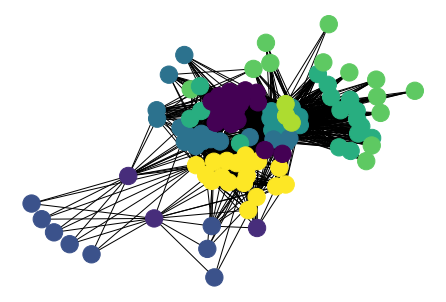

In [5]:
nx.draw(nx.from_numpy_matrix(trophic_A), node_color=sbm_model.Z)
print("Clusters for trohic layer:", sbm_k)

## Comparison of learned SBM clusters and reported clusters from Kefi et al.
(Note: inter-cluster interaction probabilities incoming and outgoing for trophic interactions reported in kefi et al are averaged to compare models learned for *undirected* networks)

Using the ICL criterion, we find 9 instead of 14 clusters. Qualitatively we see the following patterns that are shared between both the reported interaction probabilities and the probabalities that our model produces.
1. Intra-cluster interaction probabilities are close to 0 for *most* clusters. Two species in the same cluster tend not interact.
2. In both models, there are only few clusters that interact with most other clusters with moderate strength. (i.e. Cluster 8 for our SBM, and clusters 0,1, and 13.
3. Suprisingly, the plotted heatmaps have arguably a similar shape.
4. The learned cluster probabilities in the SBM for strongly interacting clusters is much higher in the SBM, this may be due to the near hard-clustering local optima enforced by a spectral clustering initialization.

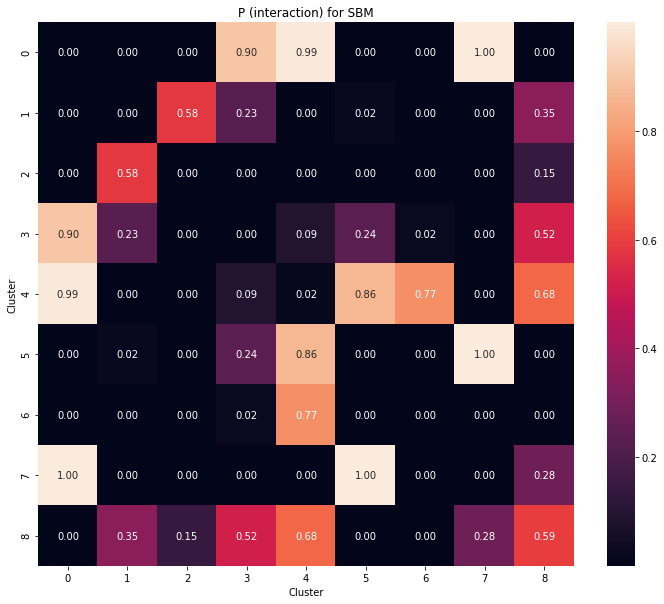

In [6]:
heatmap(sbm_model.theta, 'Cluster', 'Cluster', 'P (interaction) for SBM')

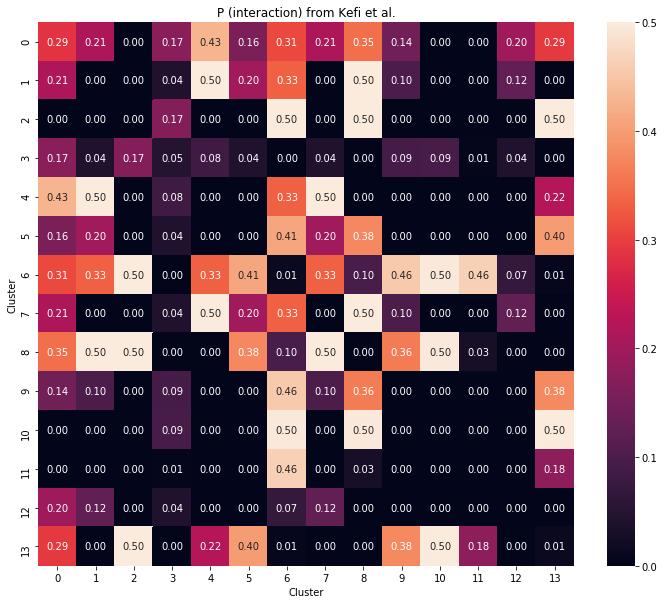

In [7]:
heatmap(load_trophic_cluster_probs(), 'Cluster', 'Cluster', 'P (interaction) from Kefi et al.')

# Comparison of probabilistic generative model (SBM) vs non-probabilistic model (Louvain clustering)

We set the resolution of the louvain clustering to `0.7` so as to report the same number of clusters as the learned SBM

In [8]:
trophic_louvain_labels, trophic_louvain_k = louvain(trophic_A, 0.7)

Louvain Clusters for trohic layer: 9


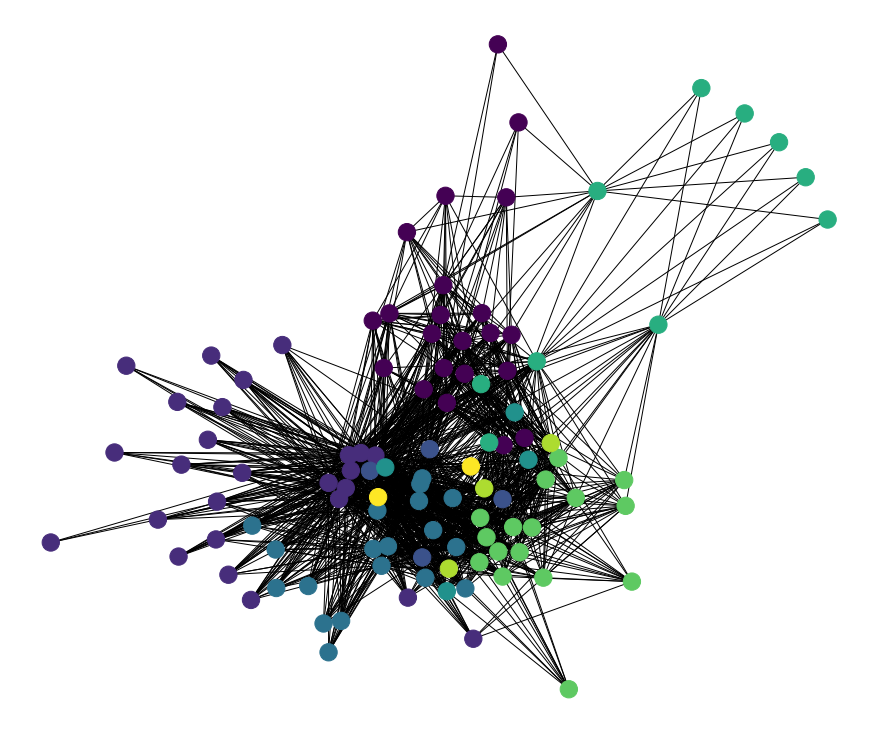

In [9]:
nx.draw(nx.from_numpy_matrix(trophic_A), node_color=trophic_louvain_labels)
print("Louvain Clusters for trohic layer:", trophic_louvain_k)

The learned clusters from the SBM and Louvain clustering largely do not agree.
1. Clusters 0 and 8 from Louvain clustering and SBM have high similarity (~0.67)
2. Several other clusters have moderate similarity clusters (5,2) and (1,7)

Though the two clustering algorithms do not agree, not all clusters are equally similar. Further, the plotted networks do indeed show that nodes are indeed clustered when plotted under a spectral embedding (as is defaulted in networkX). This suggests that both models are doing something reasonable. A likely hypothesis for why the odels do not agree is that the two models, Louvain clustering and SBM, capture different notions of separation or cuts in the graph.

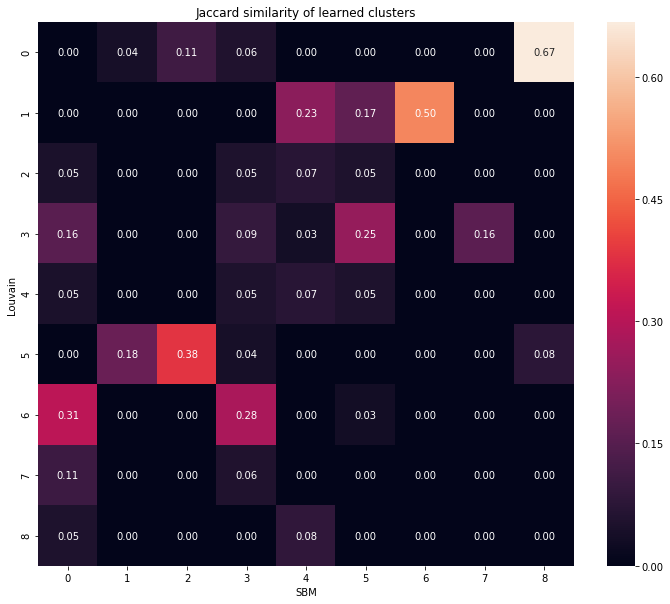

In [10]:
sims = cluster_jaccard(trophic_louvain_labels, trophic_louvain_k, sbm_model.Z, sbm_k)
heatmap(sims, 'SBM', 'Louvain', 'Jaccard similarity of learned clusters')

# Comparison of SBM to Kefi et al.

We compare our 9 clusters to the 14 clusters (based on trophic interactions) reported by kefi et al.
1. Naievely clusters 0 and 4 of the learned SBM recapitulate clusters 3 and 0 reported by kefi et al.

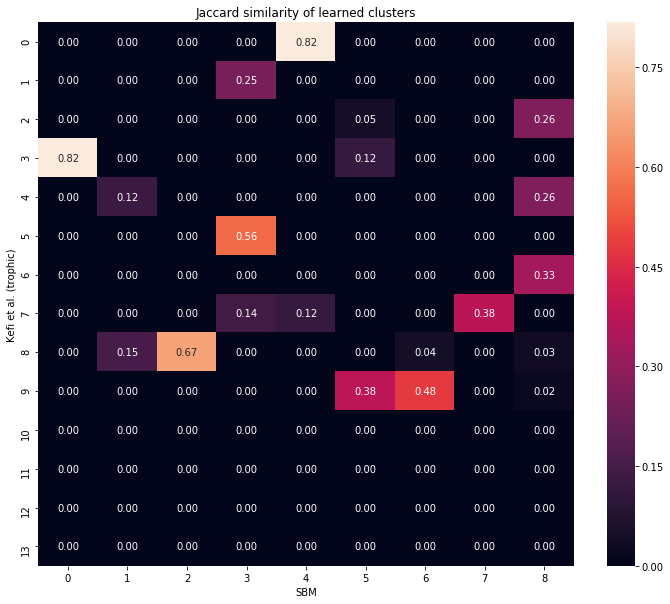

In [11]:
sims = cluster_jaccard(load_trophic_clust_labels(), 14, sbm_model.Z, sbm_k)
heatmap(sims, 'SBM', 'Kefi et al. (trophic)', 'Jaccard similarity of learned clusters')

For trophic interactions, species are only assigned to 10 unique clusters [0, 9].

In [12]:
len(np.unique(load_trophic_clust_labels())), np.unique(load_trophic_clust_labels())

(10, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

If we hand-pick clusters in the learned SBM and those reported by Kefi et al and merge them, we get a *much* stronger correspondence between the reported results and our attempted reproduction.

We merge clusters (2,4,6) and (1,5,7) in Kefi et al. We merge clusters (6,5), (1,2) and (3,7) in our learned SBM. This gives us the following correspondences between our learned clusters and reported clusters in Kefi et al.

| SBM clusters | Kefi et al. clusters | Jaccard sim. |
|--  |--    |--   |
|0   |3     | 0.82|
|1,2 | 8    | 0.77|
|3, 7| 1,5,7| 0.90|
|4   | 0    | 0.82|
|5,6 | 9    | 0.77|
|8   | 2 4,6| 0.80|

This merging gives a strong correspondance between partitionings of the learned SBM clusters and the reported clusters. This suggests that the models are sensitive to intialization. There is a correspondance between our clusers and the reported clusters, however, it is not clear if their clusters can be easily reproduced!

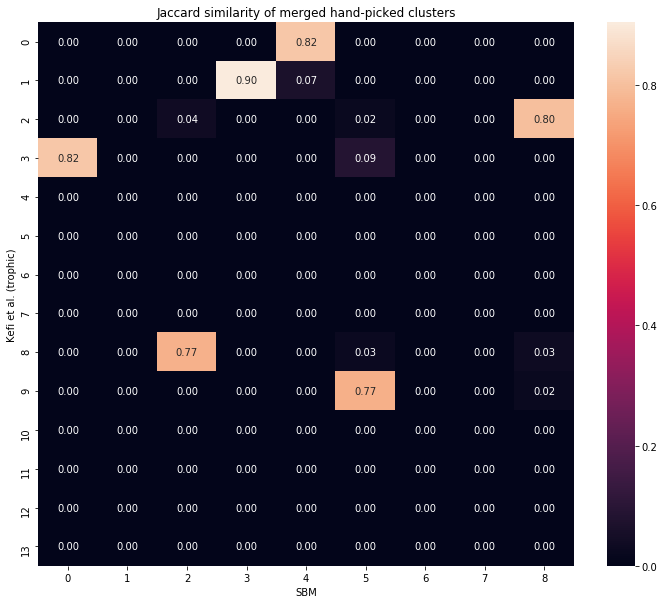

In [13]:
new_Z = load_trophic_clust_labels()
new_Z[new_Z==6] = 2
new_Z[new_Z==4] = 2

new_Z[new_Z==5] = 1
new_Z[new_Z==7] = 1

new_Z2 = sbm_model.Z.copy()
new_Z2[new_Z2 == 6] = 5

new_Z2[new_Z2==1] = 2
new_Z2[new_Z2==7] = 3

sims = cluster_jaccard(new_Z, 14, new_Z2, sbm_k)
heatmap(sims, 'SBM', 'Kefi et al. (trophic)', 'Jaccard similarity of merged hand-picked clusters')